# Imports

In [1]:
!pip install tensorflow_hub
!pip install keras tf-models-official pydot graphviz

In [2]:
import os

import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub

from keras.utils import np_utils

import official.nlp.bert.bert_models
import official.nlp.bert.configs
import official.nlp.bert.run_classifier
import official.nlp.bert.tokenization as tokenization

from official.modeling import tf_utils
from official import nlp
from official.nlp import bert

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import confusion_matrix,classification_report

import matplotlib.pyplot as plt

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

1 Physical GPUs, 1 Logical GPUs
Version:  2.5.0
Eager mode:  True
Hub version:  0.12.0
GPU is available


# Data

In [4]:
data_train = pd.read_excel('.....',names=["ID","Tweets","Labels"])
data_train.Labels = data_train.Labels.map({'not': 'NOT', 'OFf': 'OFF','NOT': 'NOT', 'OFF': 'OFF'})
data_train.dropna(inplace=True)
data_train.reset_index(drop=True, inplace=True)

data_test = pd.read_csv(".....",names=["ID","Tweets","Labels"])
data_test.dropna(inplace=True)
data_test.reset_index(drop=True, inplace=True)

In [5]:
x_train = data_train.Tweets
x_test = data_test.Tweets
y_train = data_train.Labels
y_test = data_test.Labels

## Label Encoding

In [6]:
encoder = LabelEncoder()
encoder.fit(y_test)

encoded_Y_test = encoder.transform(y_test)
encoded_Y_train = encoder.transform(y_train)


dummy_y_test = np_utils.to_categorical(encoded_Y_test)
dummy_y_train = np_utils.to_categorical(encoded_Y_train)

## Tokenization

Using the pre trained BERT tokenization technique for the respective model. For all BERT option visit [here.](https://tfhub.dev/google/collections/bert/1)


In [7]:
#Multi cased Large bert model was used

bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/2",
                            trainable=True)

In [8]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [9]:
tokenizer.convert_tokens_to_ids(['[CLS]', '[SEP]'])

[101, 102]

In [10]:
def encode_names(n):
   tokens = list(tokenizer.tokenize(n))
   tokens.append('[SEP]')  # seperation token. Would bemuch more useful if you had a multiple text input.
   return tokenizer.convert_tokens_to_ids(tokens)

tweets = tf.ragged.constant([
    encode_names(n) for n in x_train])

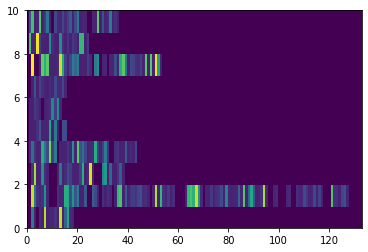

In [11]:
cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*tweets.shape[0]
input_word_ids = tf.concat([cls, tweets], axis=-1)

## Mask and input type

The model expects two additional inputs:

* The input mask
* The input type

The mask allows the model to cleanly differentiate between the content and the padding. The mask has the same shape as the `input_word_ids`, and contains a `1` anywhere the `input_word_ids` is not padding.

In [12]:
input_mask = tf.ones_like(input_word_ids).to_tensor()

In [13]:
type_cls = tf.zeros_like(cls)
type_tweet = tf.ones_like(tweets)
input_type_ids = tf.concat([type_cls, type_tweet], axis=-1).to_tensor()

## Remake into a function for normal use

So at this point we have all of our three inputs:

1.   Tokens
2.   Input mask
3.   Input type

It will make our work easier both now and in the future if we remake everything into funcitons.



First let's set the max sequence lenght as we did in simple NN example.

In [14]:
lens = [len(i) for i in input_word_ids]

In [15]:
max_seq_length = max(lens)
print('Max length is:', max_seq_length)

Max length is: 165


In [16]:
max_seq_length = 120

Functions themselves.

In [17]:
def encode_names(n, tokenizer):
   tokens = list(tokenizer.tokenize(n))
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)

def bert_encode(string_list, tokenizer, max_seq_length):
  num_examples = len(string_list)
  
  string_tokens = tf.ragged.constant([
      encode_names(n, tokenizer) for n in np.array(string_list)])

  cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*string_tokens.shape[0]
  input_word_ids = tf.concat([cls, string_tokens], axis=-1)

  input_mask = tf.ones_like(input_word_ids).to_tensor(shape=(None, max_seq_length))

  type_cls = tf.zeros_like(cls)
  type_tokens = tf.ones_like(string_tokens)
  input_type_ids = tf.concat(
      [type_cls, type_tokens], axis=-1).to_tensor(shape=(None, max_seq_length))

  inputs = {
      'input_word_ids': input_word_ids.to_tensor(shape=(None, max_seq_length)),
      'input_mask': input_mask,
      'input_type_ids': input_type_ids}

  return inputs

And now we preprocess inputs.

In [18]:
X_train = bert_encode(x_train, tokenizer, max_seq_length)
X_test = bert_encode(x_test, tokenizer, max_seq_length)

## Initial training

In [19]:
num_class = len(encoder.classes_)

input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                       name="input_word_ids")
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                   name="input_mask")
segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                    name="segment_ids")

pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])                                  

output = tf.keras.layers.Dropout(rate=0.1)(pooled_output)

output = tf.keras.layers.Dense(num_class, activation='softmax', name='output')(output)

model = tf.keras.Model(
    inputs={
        'input_word_ids': input_word_ids,
        'input_mask': input_mask,
        'input_type_ids': segment_ids
        },
        outputs=output)

Our model.

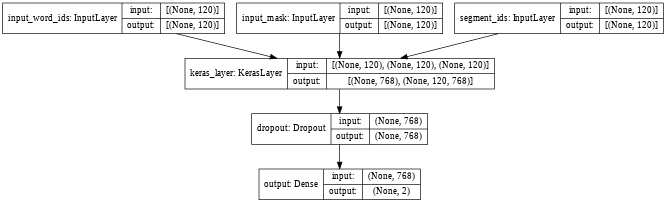

In [20]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=48)

Set up the training parameters.

In [21]:
epochs = 5
batch_size = 16
eval_batch_size = batch_size

train_data_size = len(dummy_y_train)
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(epochs * train_data_size * 0.1 / batch_size)

optimizer = nlp.optimization.create_optimizer(
    2e-5, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps)

Compile the model.

In [22]:
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [23]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 120)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 120)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 120)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 177853441   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

Set up a history to check our model performance afterwards.

In [24]:
history = model.fit(X_train,
                    dummy_y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_test, dummy_y_test),
                    verbose=1)

Epoch 1/5
250/250 [==============================] - 133s 477ms/step - loss: 0.5491 - accuracy: 0.6957 - val_loss: 0.4127 - val_accuracy: 0.8053
Epoch 2/5
250/250 [==============================] - 122s 490ms/step - loss: 0.3697 - accuracy: 0.8342 - val_loss: 0.2699 - val_accuracy: 0.8830
Epoch 3/5
250/250 [==============================] - 124s 495ms/step - loss: 0.2840 - accuracy: 0.8942 - val_loss: 0.2814 - val_accuracy: 0.8840
Epoch 4/5
250/250 [==============================] - 124s 497ms/step - loss: 0.2149 - accuracy: 0.9282 - val_loss: 0.3233 - val_accuracy: 0.8840
Epoch 5/5
 31/250 [==>...........................] - ETA: 1:42 - loss: 0.1588 - accuracy: 0.9577

KeyboardInterrupt: ignored

Evaluation

In [25]:
loss, accuracy = model.evaluate(X_train, dummy_y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, dummy_y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9655
Testing Accuracy:  0.8957


In [29]:
y_pred = model.predict(X_test)
y_pred = y_pred.argmax(axis=-1)
y_pred = encoder.inverse_transform(y_pred)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         NOT       0.92      0.87      0.89       465
         OFF       0.88      0.92      0.90       475

    accuracy                           0.90       940
   macro avg       0.90      0.90      0.90       940
weighted avg       0.90      0.90      0.90       940



In [30]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [31]:
plot_history(history)

NameError: ignored